In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib

Ethen 2016-08-03 23:26:43 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


# Multi-Armed Bandits

Imagine this scenario: You’re in a casino. There are many different slot machines (known as "one-armed bandits", as they’re known for robbing you), each with a lever (an arm, if you will). You think that some slot machines payout more frequently than others do, and you’re goal is to walk out of the casino with the most money. 

The question is, how do you learn which slot machine is the best and get the most money in the shortest amount of time? You could try all the slot machines out to get a sense of the expected return from playing each machine. But remember, each time you play a poor performing machine, you lower your take that you walk out of the casino with that night. In order to maximize how much money you walk out of the casino with, you will have to be efficient with how you collect your data.

Rewriting the scenario above into a business language. Each time a shopper looks comes to a webpage, we  show them one of the $K$ variations of the webpage. They either click on it or do not, and we log this information about the (binary) reward for each $K$ variations. Kext, we proceed to the next shopper or have to choose one of $K$ webpage variations again.


## Differences Between A/B Testing and Bandit Testing

In both scenarios above, we would normally determine our "winner" (the slot machine that pays the most, or the best webpage variations that gets the most clicks) using the well-known **A/B testing** approach. The **A/B testing** approach consists of a period of pure exploration, where you’re randomly assigning equal numbers of users to one of the $K$ variations and run the test until it's valid. After that, it jumps into pure exploitation, where you send 100% of your users to the more successful version of your site.

Two possible problems with the classical **A/B testing** approach is that:

- It jumps discretely from exploration to exploitation, when you might be able to transition more smoothly.
- During the exploratory phase (the test), it wastes resources exploring inferior options in order to gather as much data as possible.

Given the exploration - exploitation dilemma stated above, the **bandit testing** approach try to account for this. The following graph depicts the difference between the two types of testing method: 

<img src="compare_testing.png" width="700" height="700">

If we have three variations that we wish to test, the **A/B testing** approach we try out each of the three variations with equal proportions until we run our test at week 5, and then select the variation with the highest value. 

As for **bandit testing**, it attempts to use what it knows about each variation from the very beginning, and it continuously updates the probabilities that it will select each variation throughout the optimization process. In the above chart we can see that with each new week, the **bandit testing** reduces how often it selects the lower performing options and increases how often if selects the highest performing option.

> You need to explore in order to figure out what works and what doesn’t. On the other hand, if you exploit you take advantage of what you have learned. The **bandit testing** approach highlights the fact that collecting data also has its cost.

To be specific, **bandit testing** algorithms will try to minimize what’s known as regret, which is the difference between your actual payoff and the payoff you would have collected had you played the optimal (best) options at every opportunity. There are tons of different bandit methods, in the next section we'll look at some of the more common ones.

## Bandit Algorithms

Before introducing the algorithms and trying them out through simulations, we'll denote some notations and terminologies to formally define the problem:

- **arms** is simply the variations that we're testing (webpages that we're testing) and there will be $K$ of them in total.
- In a simulation of t turns (how many samples in a simulation), we'll maintain **empirical means** of the reward for each arm (e.g. after trying out arm A for 10 turns, it got 3 clicks, the empirical means is simply 0.3) that are updated at every turn t.
- $u_i(t)$ is the empirical mean of arm $i$ after $t$ turns.
- $p_i(t)$ is the probability of picking arm $i$ at turn $t$.

Let's look at our simulated data beforing diving into each algorithms (hopefully the docstrings are self-explanatory).

In [3]:
def generate_bernoulli_bandit_data( simulation_num, K ):
    """
    generate simluate data, that represents success / trial data
    
    Parameters
    ----------
    simulation_num : int
        the total number of turns in a simulation
        
    K : int
        the total number of arms
    
    Returns
    -------
    ctr : float 1d-array, shape( K, )
        the randomly generated empirical click through rate for each arm
    
    rewards : boolean 2d-array, shape( simulation_num, K )
        given the empirical ctr, simulate in each turn of the simulation, 
        whether the arm gets pulled will obtain the 
        reward or not (whether the webpage gets clicked)
    """

    ctr = np.random.rand(K)
    rewards = np.random.rand( simulation_num, K ) < np.tile( ctr, ( simulation_num, 1 ) )
    return ctr, rewards 

K = 2
simulation_num = 5
ctr, rewards  = generate_bernoulli_bandit_data( simulation_num, K )
print(ctr)
print(rewards)

[ 0.83048333  0.70861533]
[[ True False]
 [ True  True]
 [ True  True]
 [ True False]
 [ True  True]]


### Algorithm 1 - Epsilon Greedy 

At each round $t = 1, 2, ...$ the **Epsilon Greedy** algorithm will:

- Choose a random arm with the probability of $\epsilon$.
- Choose the arm with the current best empirical mean with probability of $1-\epsilon$.

In mathematical notations:

$$
p_i(t+1)=
\begin{cases}
    1 - \epsilon + \epsilon \big/ K & \quad \text{if i = } argmax_{j = 1, ..., K} \ u_j(t) \\
    \epsilon \big/ K  & \quad otherwise
\end{cases}
$$

Or more intuitively:

- When a new visitor comes to the site, the algorithm flips a coin that comes up tail with the probability of $\epsilon$. When it does in fact comes up tail, the algorithm is going to explore. The exploration phase is simply randomly choosing between any possible arm with equal (uniform) probability and showing it to the visitor.
- On the other hand, the algorithm will exploit the best known solution with the proability of $1- \epsilon$. To exploit, the algorithm simply looks up the current empirical means and shows the best one to the visitor.

The image below sums up the algorithm pretty well.

<img src='epsilon_greedy.png' width = 700 height = 700>

In [4]:
def epsilon_greedy( counts, epsilon = 0.5, decrease_const = 1000 ):
    """
    adaptive epsilon greedy
    
    Parameters
    ----------
    counts : int 2d-array, shape( K, 2 ), where K = the total number of arms
        success and failures for each arm where column 0 represents 
        success, 1 represents failure
    
    epsilon : float
        the initial probability of choosing a random arm; 
        1 - epsilon is the probability of choosing the current best arm
        
    decrease_const : int
        parameter for the adaptive (annealing) epsilon
    
    Returns
    -------
    (int) the chosen arm
    """
    
    # calculate the empirical means and the total number of simulations that were ran
    totals = counts.sum( axis = 1 )
    successes = counts[ :, 0 ]
    empirical_means = successes / totals
    total_counts = counts.sum()
    
    epsilon /= ( 1 + total_counts / decrease_const )
    if np.random.rand() > epsilon:
        return np.argmax(empirical_means)
    else:
        return np.random.randint( 0, empirical_means.shape[0] )

# counts : stores the counts of success and failures for each arm
# where column 0 represents success, 1 represents failure.
# each arm's count is initialiated as 1 to ensure that each arm is
# played at least once, to prevent "cold start" problem and
# 0 division in the beginning
counts = np.ones( ( K, 2 ) )
print(counts)
epsilon_greedy(counts)

[[ 1.  1.]
 [ 1.  1.]]


0

The `decrease_const` parameter in the function above may look unfamiliar.

For the **Epsilon Greedy** algorithm, setting the $\epsilon$ can be a bit tricky. If it’s too small, exploration will be slow at the beginning, and you will be slow to react to changes. If we happen to sample, say, the second-best arm the first few times, it may take a long time to discover that another arm is actually better. If $\epsilon$ is too big, you’ll waste many trials pulling random arms without gaining much.

To accomodate for this situation, we will set the $\epsilon$ value at a higher value in the beginning and anneal (gradually lower) it over time. Intuitively, this simply means that after exploring around for a while, we become more certained about each arms' empirical means. After that, it's better to exploit. 

In the function call above, the $\epsilon$ at turn $t$ will become:

$$\epsilon(t) = \epsilon(0) \Big/ (1 + t/T)$$

Where $T$ is a new parameter that represents a decreasing constant.

Note that there are different ways of annealing a parameter, but the spirit is the same.

In [5]:
# show adaptive learning rate
epsilon = 0.5
decrease_const = 1000

# the epsilon value after 10 turns
total_counts = 10
print( epsilon / ( 1 + total_counts / decrease_const ) )

# after 10000 turns
total_counts = 10000
print( epsilon / ( 1 + total_counts / decrease_const ) )

0.49504950495049505
0.045454545454545456


### Algorithm 2 - Boltzmann Exploration (Softmax)

The **Softmax** algorithm picks each arm with a probability that is proportional to its average reward.

$$ p_i(t+1)= \frac{ e^{u_i(t) / \tau} }{ \sum_{j=1}^K  e^{u_j(t) / \tau} }$$

Where $\tau$ is a temperature parameter, controlling the randomness of the choice. When $\tau$ = 0, the algorithm acts like pure greedy. As $\tau$ grows to infinity, the algorithm will pick arms uniformly at random.

In [6]:
def softmax(counts):
    """
    adaptive softmax
    
    Parameters
    ----------
    counts : int 2d-array, shape( K, 2 ), where K = the total number of arms
         success and failures for each arm where column 0 represents 
         success, 1 represents failure
    
    Returns
    -------
    (int) the chosen arm
    """
    
    # calculate the empirical means and the total number of simulations that were ran
    totals = counts.sum( axis = 1 )
    successes = counts[ :, 0 ]
    empirical_means = successes / totals
    total_counts = counts.sum()
    
    # annealing (adaptive learning rate)
    tau = 1 / np.log( total_counts + 0.000001 )

    probs_n = np.exp( empirical_means / tau )
    probs_d = probs_n.sum()
    probs = probs_n / probs_d

    cum_prob = 0.
    z = np.random.rand()
    for idx, prob in enumerate(probs):  
        cum_prob += prob
        if cum_prob > z:
            return(idx)

counts = np.ones( ( K, 2 ) )
softmax(counts)

1

### Algorithm 3 - Upper Confidence Bounds (UCB)

In the world of statistics, whenever you estimate some unknown parameter (such as the mean of a distribution) using random samples, there is a way to quantify the uncertainty inherent in your estimate.  For example, the true mean of a fair six-sided die is 3.5.  But if you only roll it once and get a 2, your best estimate of the mean is just 2.  Obviously that estimate is not very good, and we can quantify the confidence we have for our estimate.  There are confidence bounds which can be written, for example, as: "The mean of this die is 2, with a 95-th percentile lower bound of 1.4 and a 95-th percentile upper bound of 5.2."

The upper confidence bound (UCB) family of algorithms, as its name suggests, simply selects the arm with the largest upper confidence bound at each turn.  The intuition is this: the more times you roll the die, the tighter the confidence bounds, on the other hand, if your roll the die an infinite number of times then the width of the confidence bound is zero. In short, as the number of rolls increases, the uncertainty decreases, and so does the width of the confidence bound. 

Thus, unlike the **Epsilon Greedy** and **Softmax** algorithm that only keeps track of the empirical means, the **UCB** algorithm also maitains the number of times that each arm has been played, denoted by $n_i(t)$. Initially, each arm is played once. Afterwards, at round t, the algorithm greedily picks the arm $j(t)$ as follows:

$$j(t) = argmax_{i = 1, ..., K} \left( u_i + \sqrt{\frac{2lnt}{n_i}} \right)$$

We can see that the **UCB** algorithm will try to learn about arms that we don't know enough about. The main advantages of these types of algorithms are:

- Take uncertainty of sample mean estimate into account in a smart way.
- No parameters (e.g. epsilon, annealing) to validate.

In [7]:
def ucb(counts):
    """
    adaptive softmax
    
    Parameters
    ----------
    counts : int 2d-array, shape( K, 2 ), where K = the total number of arms
         success and failures for each arm where column 0 represents 
         success, 1 represents failure
    
    Returns
    -------
    (int) the chosen arm
    """
    
    # calculate the empirical means and the total number of simulations that were ran
    totals = counts.sum( axis = 1 )
    successes = counts[ :, 0 ]
    empirical_means = successes / totals
    total_counts = counts.sum()
    
    bonus = np.sqrt( 2 * np.log(total_counts) / totals )
    return np.argmax( empirical_means + bonus )

counts = np.ones( ( K, 2 ) )
softmax(counts)

1

## Experimenting With Bandit Algorithms

In this section, we'll use our simulated data to experiment with our algorithms. To do this we'll also need a metric to calculate how well we are doing. Recall the absolute *best* we can do is to always pick the webpage (arm) with the largest click through rate (ctr). Denote this best arm's probability of $w_{opt}$. Our score should be relative to how well we would have done had we chosen the best arm from the beginning. This motivates the *total regret* of a strategy, defined as:

$$
\begin{align}
R_T & = \sum_{t=1}^{T} \left( w_{opt} - w_{I(t)} \right) \nonumber \\
& = Tw_{opt} - \sum_{t=1}^{T} \;  w_{I(t)} \nonumber
\end{align}
$$

Where $T$ is the total number of samples in the experiment, $w_{I(t)}$ is the probability of obtaining the reward (getting clicked) of the chosen arm in the $t_{th}$ turn. A total regret of 0 means the strategy is attaining the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice. Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{I(t)} = w_{opt}$ often)

We'll run the experiment and plot the cumulative regret of the three algorithms below:

In [8]:
def run_bandit_algo( rewards, ctr, algo, **kwargs ):
    """
    Run different types of bandit algorithms
    
    Parameters
    ----------
    rewards, ctr : 
        Return value of the `generate_bernoulli_bandit_data` function
    
    algo : bandit function
        [ epsilon_greedy, softmax, ucb ]
    
    **kwargs :
        additional parameters to pass in to the algo
    
    Returns
    -------
    cum_regret : 1d-array, shape( simulation_num, )
        The total regret accumulated over the experiment, where the regret
        is measured by the maximum ctr - the chosen arm's ctr 
    
    opt_arm_percentage : float
        The percentage of plays in which the optimal arm is pulled
    """  
    simulation_num, K = rewards.shape
    
    # counts : success and failures for each arm where column 0 represents 
    # success, 1 represents failure. Each arm's count is initialiated as 1 
    # to ensure that each arm is played at least once, to prevent "cold start" 
    # problem and 0 division in the beginning
    counts = np.ones( ( K, 2 ), dtype = int )   
    regret = np.zeros(simulation_num)
    
    max_ctr_count = 0
    max_ctr = np.max(ctr)
    max_ctr_idx = np.argmax(ctr)
    
    for i in range(simulation_num): 
        # 1. run the algorithm to obtain the arm that got pulled 
        # 2. update the success / failure according to the generated rewards
        # 3. update the expected regret for each turn of the simulation
        # 4. if the arm that got pulled is the one with the opt ctr, increment this count      
        arm = algo( counts, **kwargs )
        
        if rewards[ i, arm ] == 1:
            counts[ arm, 0 ] += 1
        else:
            counts[ arm, 1 ] += 1

        regret[i] = max_ctr - ctr[arm]
        
        if arm == max_ctr_idx:
            max_ctr_count += 1

    cum_regret = np.cumsum(regret)
    opt_arm_percentage = max_ctr_count / simulation_num
    return cum_regret, opt_arm_percentage

In [9]:
K = 5
simulation_num = 10000
algorithms = [ epsilon_greedy, softmax, ucb ]

def run_experiment( K, simulation_num, algorithms ):
    """
    Run the bandit algorithm's simulation by the 
    specified number of samples for simulation, the number of arms
    and the different version of algorithm
    
    Parameters
    ----------
    simulation_num : int
        the total number of turns in a simulation
        
    K : int
        the total number of arms
    
    algorithms : list of functions
        the list of bandit algorithms to simulate
    
    Returns
    -------
    ctr : float 1d-array, shape( K, )
        the randomly generated empirical click through rate for each arm 
    
    algo_opt_arm_percentage : float list
        the percentage of simulations that chose the best arm
        
    algo_cum_regret : float 2d-array, shape( simulation_num, length of the algorithm )
        each column stores the cumulative regret for one algorithm
        
    fig : matplotlib figure
        the cumulative regret for each bandit algorithm
    """
    algo_opt_arm_percentage = []
    algo_cum_regret = np.zeros( ( simulation_num, len(algorithms) ) )   

    fig = plt.figure( figsize = ( 10, 7 ) )
    ctr, rewards = generate_bernoulli_bandit_data( simulation_num, K )
    
    for idx, algo in enumerate(algorithms):
        cum_regret, opt_arm_percentage = run_bandit_algo( rewards, ctr, algo = algo )
        algo_cum_regret[ :, idx ] = cum_regret
        algo_opt_arm_percentage.append(opt_arm_percentage)
        
        plt.semilogy( cum_regret, label = algo.__name__ )

    plt.title( 'Simulated Bandit Performance for K = {}'.format(K) )
    plt.ylabel('Cumulative Expected Regret')
    plt.xlabel('Round Index')
    plt.legend( loc = 'lower right' )
    
    return ctr, algo_opt_arm_percentage, algo_cum_regret, fig

[ 0.6869894   0.25020221  0.7358202   0.52046156  0.81909791]
[0.9059, 0.5619, 0.8398]


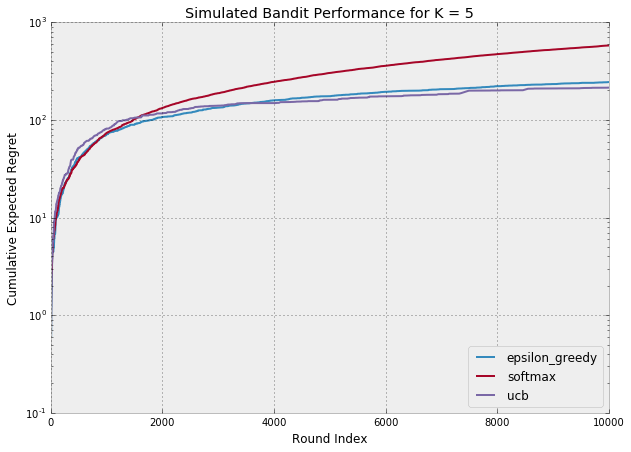

In [10]:
ctr, algo_opt_arm_percentage, algo_cum_regret, fig = run_experiment( K, simulation_num, algorithms )
fig.show()
print(ctr)
print(algo_opt_arm_percentage)

**Section Conclusion:** The plot of the cumulative expected regret of the experiment above showed that all three different algorithms have converged (the cumulative expected regret gradually decreases to a steady level). And the **UCB** seems to be doing better than the other two algorithms in this limited horizon.

In [11]:
%matplotlib inline
import numpy as np
from scipy.stats import beta
import matplotlib.pylab as plt
from collections import namedtuple

# Bayesian Bandits

All of that was great, so what's next? Well, it turns out that none of the algorithms we used in the last section are really suitable in real world applications. Why?

Recall that in the experiment above, we tested different kinds of bandit algorithms with the assumption that there is no delay between pulling an arm and observing the result. Or, more precisely, if there is a delay, it should happen before the next timing to pull an arm. This means the following timeline is impossible: 12:00 Visitor A sees Variation 1. 12:01 visitor B sees Variation 2. 12:02 Visitor A converts.

Also if you have limited computational resources, which means that you can only update your observed data in batch every 2 hours. For these kinds of delayed batch case, the algorithms described in the last section will pull the same arm every time for those 2 hours because it is deterministic in the absence of immediate updates. To sum up, the algorithms we just described needs the distributions to be updated every single round to work properly, which may not be applicable in a lot of practical cases ....

Having that caveat in mind, we'll introduce a Bayesian method that is more "immune" to this delayed feedback problem, namely **Thompson Sampling**. 

Recall that the the problem we want to solve is the following. You have come up with $K$ different variations of the webpage (e.g. different layout) that now you wish to find the ones with the best click through rate (CTR), e.g. clicking to sign-up for the newsletter. Let's represent each CTR by $\theta_i$ - i.e., $\theta_i$ is the true probability that an individual user will click when they were shown with the $i_{th}$ webpage. It is important to note that we don't actually know what $\theta_i$ is - if we did, we could simply choose ii for which $\theta_i$ was largest and move on. We're simply pretending that we know in order to simulate the performance of the algorithm.

Using the Bayesian approach we will construct a prior probability distribution which represents our original belief about what the actual value of $\theta_i$, our ctr for the $i_{th}$ webpage is. The prior we'll use is the Beta distribution. Here's a quick recap of the distribution:

## Beta Distribution

The Beta distribution is very useful in Bayesian statistics. A random variable $X$ has a Beta distribution, with parameters $(\alpha, \beta)$, if its density function is:

$$f_X(x | \; \alpha, \beta ) = \frac{ x^{(\alpha - 1)}(1-x)^{ (\beta - 1) } }{B(\alpha, \beta) }$$

where $B$ is the [Beta function](http://en.wikipedia.org/wiki/Beta_function) (hence the name). The random variable $X$ is only allowed in [0,1], making the Beta distribution a popular distribution for decimal values, probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution. Below we plot some Beta distributions with different $\alpha$ and $\beta$ values:

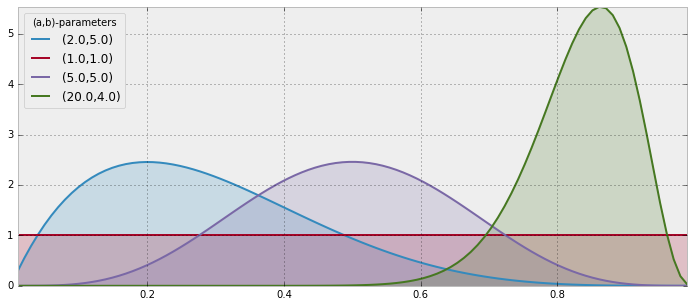

In [12]:
plt.figure( figsize = ( 12, 5 ) )

x = np.linspace( 0.01, .99, 100 )
params = [ (2, 5), (1, 1), (5, 5), (20, 4) ]

for a, b in params:
    y = beta.pdf( x, a, b )
    lines = plt.plot( x, y, label = "(%.1f,%.1f)" % ( a, b ), lw = 2 )
    plt.fill_between( x, 0, y, alpha = 0.2, color = lines[0].get_color() )
    plt.autoscale( tight = True )

plt.legend( loc = 'upper left', title = "(a,b)-parameters" )
plt.show()

There are two important things to note about the Beta distribution: 

The first is the presence of the flat distribution above, specified by parameters $(1,1)$. This is the Uniform distribution. Hence the Beta distribution is a generalization of the Uniform distribution.

The second is that there is an interesting connection between the Beta distribution and the Binomial distribution. Suppose we are interested in some unknown proportion or probability $p$. We assign a $\text{Beta}(\alpha, \beta)$ prior to $p$. We observe some data generated by a Binomial process, say $X \sim \text{Binomial}(N, p)$, with $p$ still unknown. Then our posterior *is again a Beta distribution*, i.e. $p | X \sim \text{Beta}( \alpha + X, \beta + N -X )$. Succinctly, one can relate the two by "a Beta prior with Binomial observations creates a Beta posterior".

In light of the above two paragraphs, if we start with a $\text{Beta}(1,1)$ prior on $p$ (which is a Uniform), observe data $X \sim \text{Binomial}(N, p)$, then our posterior is $\text{Beta}(1 + X, 1 + N - X)$. 

## Thompson Sampling

So after assuming the priors on the probability of ctr for each webpage. To be explicit on the phrase "assuming the priors", we will assume that we're completely ignorant of these probabilities. So a very natural prior is the flat prior over 0 to 1, $\text{Beta}(\alpha=1,\beta=1)$. The algorithm then proceeds as follows:

For each turn:

1. Sample a random variable $X_i$ from the prior of arm $i$, for all $i$ ($K$ in total).
2. Select the arm with largest sample, i.e. select $i = \text{argmax}\; X_i$.
3. Observe the result of pulled arm $i$, and update your prior with that arm $i$.
4. Return to 1.

Like all the algorithms we've introduced before, **Thompson Sampling** suggests that we should not discard losers, but we should pick them at a decreasing rate as we gather confidence that there exist *better* webpages (arms). This follows because there is always a non-zero chance that a webpage with a lower ctr will get chosen, but the probability of this event decreases as we play more rounds.

In [13]:
class BayesianBandit(object):
    """
    Thompson Sampling
    
    Parameters
    ----------
    K : int
        total number of arms
        
    prior_params : list of float length 2 tuple, default None, (optional)
        each element of the list is a tuple, where each tuple
        contains the alpha and beta parameter that represents the prior
        beta distribution for each arm. If not supplied
        it will assume that all arms's prior starts with an uniform distribution
        
    Attributes
    ----------
    trials, success : int 1d-array, shape( K, )
        stores the trials and success for each arm,
        e.g. trial = [ 1, 1 ] and success = [ 0, 1 ] means 
        that both arm has been pulled once and arm 1 has generated
        the reward (clicked)
    """
    
    def __init__( self, K, prior_params = None ):
        
        if prior_params:
            priors = namedtuple( "priors", [ "alpha", "beta" ] )
            prior  = [ priors(*p) for p in prior_params ]
            self.alphas = np.array([ p.alpha for p in prior ])
            self.betas  = np.array([ p.beta  for p in prior ])
        else:
            self.alphas = np.ones(K)
            self.betas  = np.ones(K)

        self.trials  = np.zeros( K, dtype = int )
        self.success = np.zeros( K, dtype = int )
        
    def get_recommendation(self):        
        """
        for all arms, construct their beta distribution and
        draw a random sample from it, then return the arm
        with the maximum value random sample 
        """
        theta = np.random.beta( self.alphas + self.success, 
                                self.betas + self.trials - self.success )
        return np.argmax(theta)
    
    def update_result( self, arm, converted ):
        """
        override the trials and success array, the success array
        will only be updated if it has generated a reward
        """
        self.trials[arm] += 1
        if converted:
            self.success[arm] += 1

In [14]:
def experiment( T, K = None, ctr = None, prior_params = None ):
    """
    run the experiment for Thompson Sampling,
    pass in ctr, the fixed ctr for each arm
    or K, the total number of arms to run the experiment,
    if K is supplied then it will be randomly generated
    
    Parameters
    ----------
    T : int
        number of simulation in an experiment
    
    K : int, , default = None, (optional)
        total number of arms
        
    ctr : float sequence, len = K, default = None, (optional)
        the empirical click through rate for each arm
        
    prior_params : list of float length 2 tuple, default None, (optional)
        each element of the list is a tuple, where each tuple
        contains the alpha and beta parameter that represents the prior
        beta distribution for each arm. If not supplied
        it will assume that all arms's prior starts with an uniform distribution
    
    Returns
    -------
    ctr : float sequence, len = K
        the supplied or the randomly generated ctr
    
    trials, success : 2d-array, shape( T, K )
        trials and success recorded for each turn of the experiment
        
    alphas, betas : float 1d-array, shape( K, )
        the alpha and beta parameters for each arm
    """
    if ctr:
        K = len(ctr)
    else:
        ctr = np.random.rand(K)

    trials  = np.zeros( ( T, K ), dtype = int )
    success = np.zeros( ( T, K ), dtype = int )

    bb = BayesianBandit( K, prior_params )
    for t in range(T):
        arm = bb.get_recommendation()
        converted = np.random.rand() < ctr[arm]
        bb.update_result( arm, converted )
        trials[t]  = bb.trials
        success[t] = bb.success
        
    return ctr, trials, success, bb.alphas, bb.betas

In [15]:
def experiment_plot( ctr, trials, success ):
    """
    Pass in the ctr, trials and success returned
    by the `experiment` function and plot
    the Cumulative Number of Turns For Each Arm and
    the CTR's Convergence Plot side by side
    """
    T, K = trials.shape
    n = np.arange(T) + 1
    fig = plt.figure( figsize = ( 14, 7 ) )

    plt.subplot(121)
    for i in range(K):
        plt.loglog( n, trials[ :, i ], label = "arm {}".format(i + 1) )

    plt.legend( loc = "upper left" )
    plt.xlabel("Number of turns")
    plt.ylabel("Number of turns/arm")
    plt.title("Cumulative Number of Turns For Each Arm")

    plt.subplot(122)
    for i in range(K):
        plt.semilogx( n, np.zeros(T) + ctr[i], label = "arm {}'s CTR".format( i + 1 ) )

    plt.semilogx( n, ( success[ :, 0 ] + success[ :, 1 ] ) / n, label = "CTR at turn t" )

    plt.axis([ 0, T, 0, 1 ] )
    plt.legend( loc = "upper left" )
    plt.xlabel("Number of turns")
    plt.ylabel("CTR")
    plt.title("CTR's Convergence Plot")
    return fig

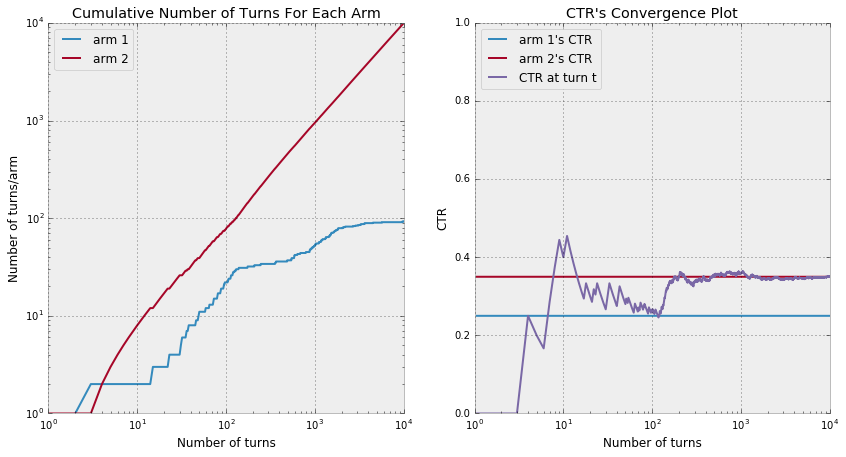

In [16]:
# number of simulation in an experiment
T = 10000

# the empirical click through rate for each arm
ctr = ( 0.25, 0.35 )

ctr, trials, success, alphas, betas = experiment( T = T, ctr = ctr )
fig = experiment_plot( ctr, trials, success )
fig.show()

In our simulation, we gave the Bayesian bandit two webpages (arms) - one had a CTR of 0.25, the other had a CTR of 0.35. To start with, both webpages were displayed to the user with roughly equal probability. Over time, evidence accumulated that arm 2 was considerably better than arm 1. At this point the algorithm switched to displaying primarily webpage 1, and the overall CTR of the experiment converged to 0.35 (the optimal CTR).

We can also visualize our Beta distribution for each arms in different turns.

In [17]:
def plot_beta_dist( ctr, trials, success, alphas, betas, turns ):
    """
    Pass in the ctr, trials and success, alphas, betas returned
    by the `experiment` function and the number of turns 
    and plot the beta distribution for all the arms in that turn
    """
    subplot_num = len(turns) / 2
    x = np.linspace( 0.001, .999, 200 )
    fig = plt.figure( figsize = ( 14, 7 ) ) 

    for idx, turn in enumerate(turns):
        plt.subplot( subplot_num, 2, idx + 1 )

        for i in range( len(ctr) ):
            y = beta( alphas[i] + success[ turn, i ], 
                      betas[i] + trials[ turn, i ] - success[ turn, i ] ).pdf(x)
            line = plt.plot( x, y, lw = 2, label = "arm {}".format( i + 1 ) )
            color = line[0].get_color()
            plt.fill_between( x, 0, y, alpha = 0.2, color = color )
            plt.axvline( x = ctr[i], color = color, linestyle = "--", lw = 2 ) 
            plt.title("Posteriors After {} turns".format(turn) )
            plt.legend( loc = "upper right" )
   
    return fig

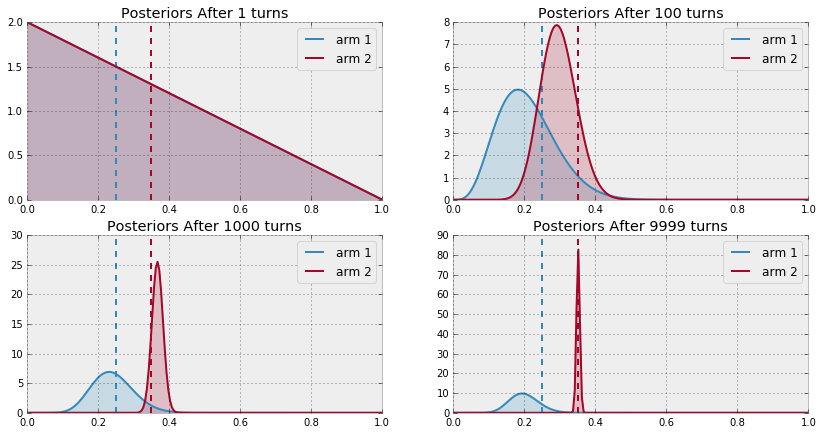

In [18]:
turns = [ 1, 100, 1000, 9999 ]
posterior_fig = plot_beta_dist( ctr, trials, success, alphas, betas, turns )
posterior_fig.show()

As you can see, we started out with some prior Beta distributions that represents the our initial beliefs about possible ctr values for each arm. We then update these beliefs based on evidence by showing different webpages to other randomly chosen users and observing the ctr. After doing this for many number of turns, we incrementally narrow the width of each arm's Beta distribution. Meaning that as we gather more data, we become more confident about each arm's actual ctr.

Note that we don't really care how accurate we become about the inference of the hidden probabilities — for this problem we are more interested in becoming more confident in choosing the best arm. This is basically why at the end of experiment, arm 1's distribution is wider. The algorithm is ignorant about what that hidden probability might be, but we are reasonably confident that it is not the best, so the algorithm chooses to ignore it.

From the above, we can see that starting after 100 pulls, the majority of arm 2's distribution already leads the pack, hence the algorithm will almost always choose this arm. This is good, as this arm is indeed better.

## Notes On Bandit Testings

In world settings, we need to account for situations such as delayed batch update or delay feedback. In such cases, algorithms such as **Epsilon Greedy**, **Softmax**, **UCB** needs the distributions to be updated every single round to work properly. On the other hand, **Thompson Sampling** is more realistic as it relies on random samples, which will be different every time even if the distributions are each arm aren't updated for a while.

So, after gaining some knowledge on **bandit testings**. The question that comes into our head is that: "In general, when is it preferred over the classical **A/B testing**?"

### Short-term testing

> "Whenever you have a small amount of time for both exploration and exploitation, use a bandit testing."

**Bandit testing** are conducive for short tests for clear reasons – if you were to run a classic **A/B testing** you’d not even be able to enjoy the period of pure exploitation. Instead, **bandit testing** allow you to adjust in real time and send more traffic, more quickly, to the better variation. Here are some possible use cases:

- **Headlines:** News has a short life cycle. Why would you run **A/B testing** on a headline if by the time you learn which variation is best, the time where the answer is applicable is over?
- **Holiday Campaigns:** e.g. If you’re running tests on an ecommerce site for Black Friday, an A/B testing isn’t that practical – you might only be confident in the result at the end of the day. On the other hand, a **bandit testing** will drive more traffic to the better-performing variation – and that in turn can increase revenue.


### Long-term testing

Because **Bandit testing** automatically shift traffic to higher performing (at the time) variations, thus it is effective in long term (or ongoing) testing where you can set it and forget about it. e.g. Serving specific ads and content to user sets (targeting ads).

## Reference

- [Algorithms for the multi-armed bandit problem](http://www.cs.mcgill.ca/~vkules/bandits.pdf)
- [Bayesian Methods for Hackers Chapter 6](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC2.ipynb)
- [Bayesian Bandits - optimizing click throughs with statistics](https://www.chrisstucchio.com/blog/2013/bayesian_bandit.html)
- [Bandits for Recommendation Systems](http://engineering.richrelevance.com/bandits-recommendation-systems/)
- [Balancing Earning with Learning: Bandits and Adaptive Optimization](http://conductrics.com/balancing-earning-with-learning-bandits-and-adaptive-optimization/)
- [Momentum and Learning Rate Adaptation](https://www.willamette.edu/~gorr/classes/cs449/momrate.html)
- [When to Run Bandit Tests Instead of A/B Tests](http://conversionxl.com/bandit-tests/)